In [1]:
!pip install kaggle dagshub mlflow -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip walmart-recruiting-store-sales-forecasting.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 597MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [5]:
!unzip train.csv.zip
!unzip stores.csv.zip
!unzip features.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.
Archive:  features.csv.zip
  inflating: features.csv            
Archive:  test.csv.zip
  inflating: test.csv                


In [25]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import logging
import cmdstanpy
import dagshub
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import pickle
import joblib

In [26]:
dagshub.init(repo_owner='Cimbir', repo_name='Store-Sales-Forecasting', mlflow=True)

Initialized MLflow to track repo "Cimbir/Store-Sales-Forecasting"

Repository Cimbir/Store-Sales-Forecasting initialized!

In [27]:
experiment_name = "Prophet_Training"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/723294fa9a3a4987bf90be420b0932f7', creation_time=1751228764096, experiment_id='1', last_update_time=1751228764096, lifecycle_stage='active', name='Prophet_Training', tags={}>

In [28]:
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [29]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

In [30]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [31]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [32]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


df = pd.merge(train, features, on=['Store', 'Date'], how='left')
df = pd.merge(df, stores, on='Store', how='left')
df = df.drop('IsHoliday_y', axis=1).rename(columns={'IsHoliday_x': 'IsHoliday'})

display(df.head())

In [33]:
df = pd.merge(train, features, on=['Store', 'Date'], how='left')
df = pd.merge(df, stores, on='Store', how='left')
df = df.drop('IsHoliday_y', axis=1).rename(columns={'IsHoliday_x': 'IsHoliday'})

# Evaluation Function

In [34]:
def WMAE(y_true, y_pred, is_holiday):
    weights = np.where(is_holiday, 5, 1)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

# Preprocess

In [35]:
class ProphetDataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df_prophet = X.copy()

        df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
        df_prophet = df_prophet.sort_values('ds')

        df_prophet['Temperature_lag1'] = df_prophet['Temperature'].shift(1)
        df_prophet['Fuel_Price_lag1'] = df_prophet['Fuel_Price'].shift(1)

        df_prophet = df_prophet.fillna(method='ffill').fillna(method='bfill')

        return df_prophet

# Training

In [36]:
class ProphetConfig:
    def __init__(self):
        self.params = {
            'yearly_seasonality': True,
            'weekly_seasonality': True,
            'daily_seasonality': False,
            'seasonality_mode': 'multiplicative',
            'changepoint_prior_scale': 0.05,
            'seasonality_prior_scale': 10.0,
            'holidays_prior_scale': 10.0,
            'mcmc_samples': 0,
            'interval_width': 0.80,
            'uncertainty_samples': 1000
        }

        self.regressors = {}

    def get_params(self):
        return self.params.copy()

    def get_regressors(self):
        return self.regressors.copy()

In [37]:
class ProphetWrapper(BaseEstimator):
    def __init__(self, config=None):
        self.config = config or ProphetConfig()
        self.model = None
        self.is_fitted = False

    def fit(self, X, y=None):
        prophet_params = self.config.get_params()
        regressors = self.config.get_regressors()

        import sys
        from io import StringIO

        old_stdout = sys.stdout
        sys.stdout = StringIO()

        try:
            self.model = Prophet(**prophet_params)

            for regressor_name, regressor_config in regressors.items():
                self.model.add_regressor(regressor_name, **regressor_config)

            required_cols = ['ds', 'y'] + list(regressors.keys())
            train_data = X[required_cols].dropna()

            self.model.fit(train_data)
            self.is_fitted = True
        finally:
            sys.stdout = old_stdout

        return self

    def predict(self, X):
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")

        regressors = self.config.get_regressors()
        required_cols = ['ds'] + list(regressors.keys())

        future = X[required_cols].copy()
        future = future.dropna()

        forecast = self.model.predict(future)

        return forecast['yhat'].values

    def predict_full(self, X):
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")

        regressors = self.config.get_regressors()
        required_cols = ['ds'] + list(regressors.keys())

        future = X[required_cols].copy()
        future = future.dropna()

        return self.model.predict(future)

    def get_params(self, deep=True):
        return {'config': self.config}

    def set_params(self, **params):
        if 'config' in params:
            self.config = params['config']
        return self

In [38]:
def create_prophet_pipeline(config=None):
    return Pipeline([
        ('preprocessor', ProphetDataPreprocessor()),
        ('prophet', ProphetWrapper(config=config))
    ])

In [39]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Store', 'Dept', 'Date'])

In [40]:
train_data = df[df['Date'] < '2012-06-01'].copy()
val_data = df[df['Date'] >= '2012-06-01'].copy()

In [41]:
def filter_sufficient_data(group):
    return len(group) >= 60

In [42]:
valid_combinations = []
for (store, dept), group in train_data.groupby(['Store', 'Dept']):
    if filter_sufficient_data(group):
        val_group = val_data[(val_data['Store'] == store) & (val_data['Dept'] == dept)]
        if len(val_group) >= 8:
            valid_combinations.append((store, dept))

print(f"Processing {len(valid_combinations)} valid store-department combinations")

Processing 2923 valid store-department combinations


Processed 100/2923 combinations
Processed 200/2923 combinations
Processed 300/2923 combinations
Processed 400/2923 combinations
Processed 500/2923 combinations
Processed 600/2923 combinations
Processed 700/2923 combinations
Processed 800/2923 combinations
Processed 900/2923 combinations
Processed 1000/2923 combinations
Processed 1100/2923 combinations
Processed 1200/2923 combinations
Processed 1300/2923 combinations
Processed 1400/2923 combinations
Processed 1500/2923 combinations
Processed 1600/2923 combinations
Processed 1700/2923 combinations
Processed 1800/2923 combinations
Processed 1900/2923 combinations
Processed 2000/2923 combinations
Processed 2100/2923 combinations
Processed 2200/2923 combinations
Processed 2300/2923 combinations
Processed 2400/2923 combinations
Processed 2500/2923 combinations
Processed 2600/2923 combinations
Processed 2700/2923 combinations
Processed 2800/2923 combinations
Processed 2900/2923 combinations


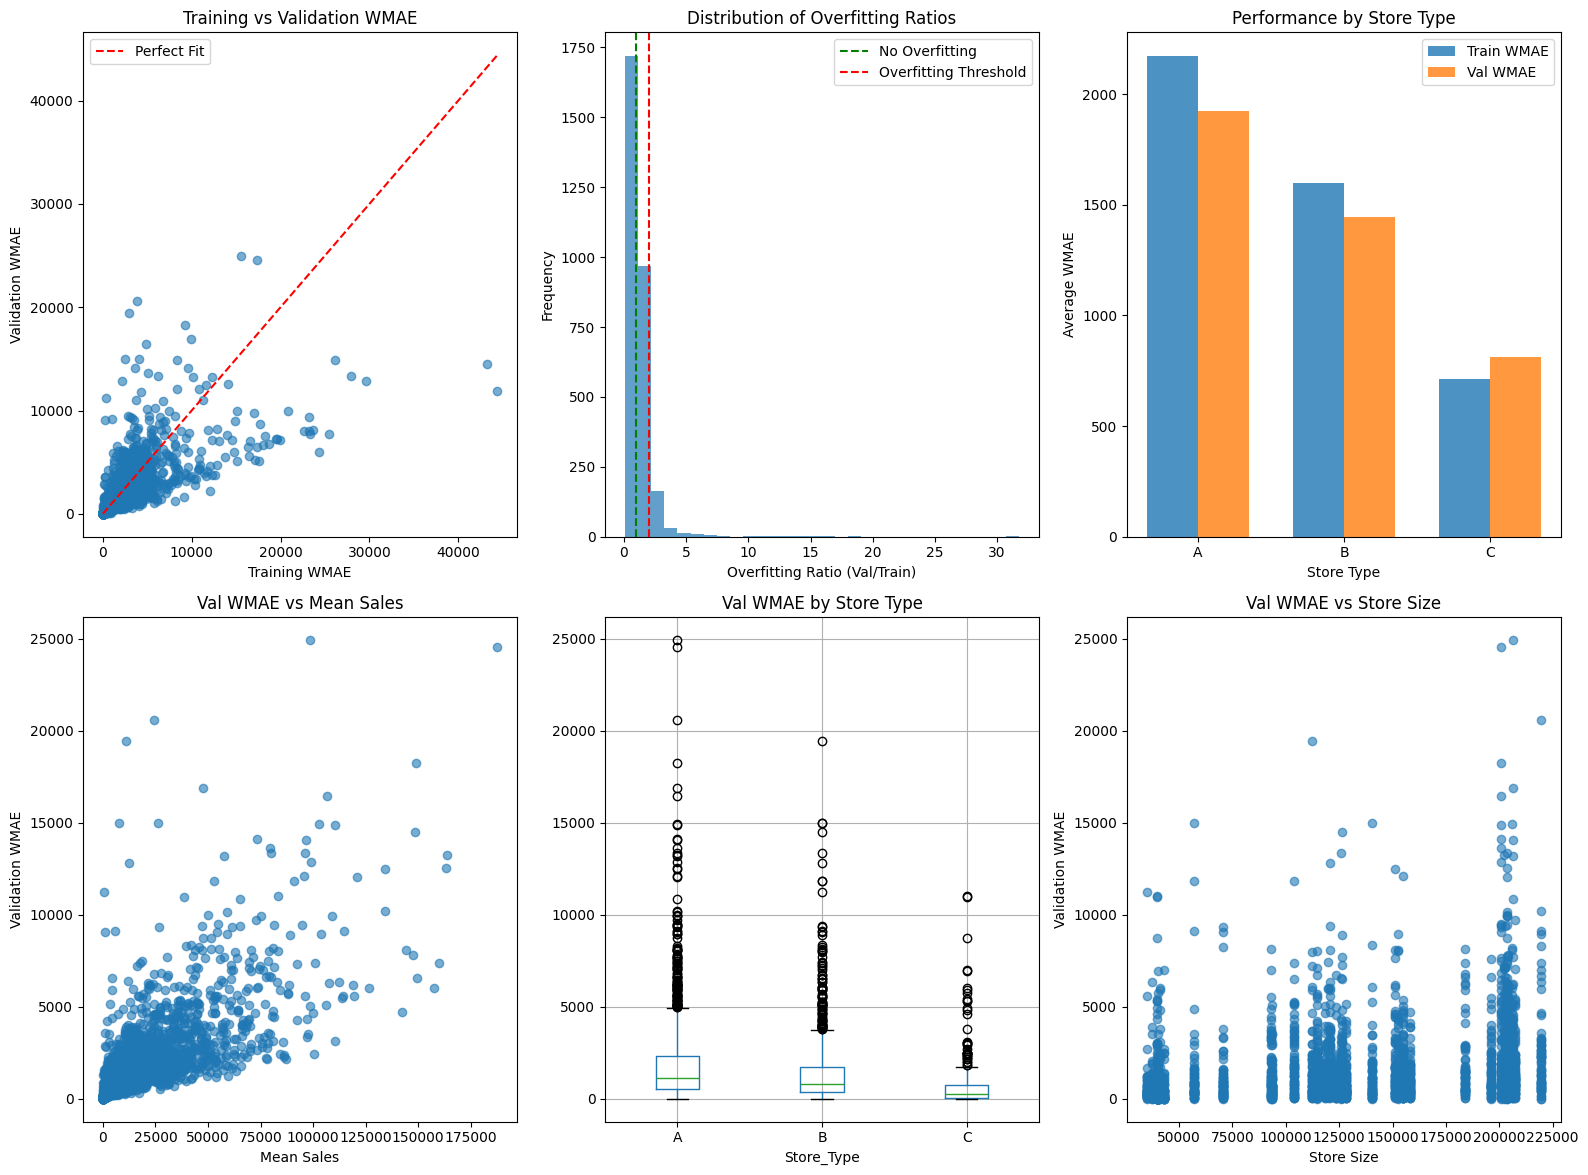


Best model: Store 30, Dept 52
Training WMAE: 7.6816
Validation WMAE: 7.0453
Overfitting Ratio: 0.9172


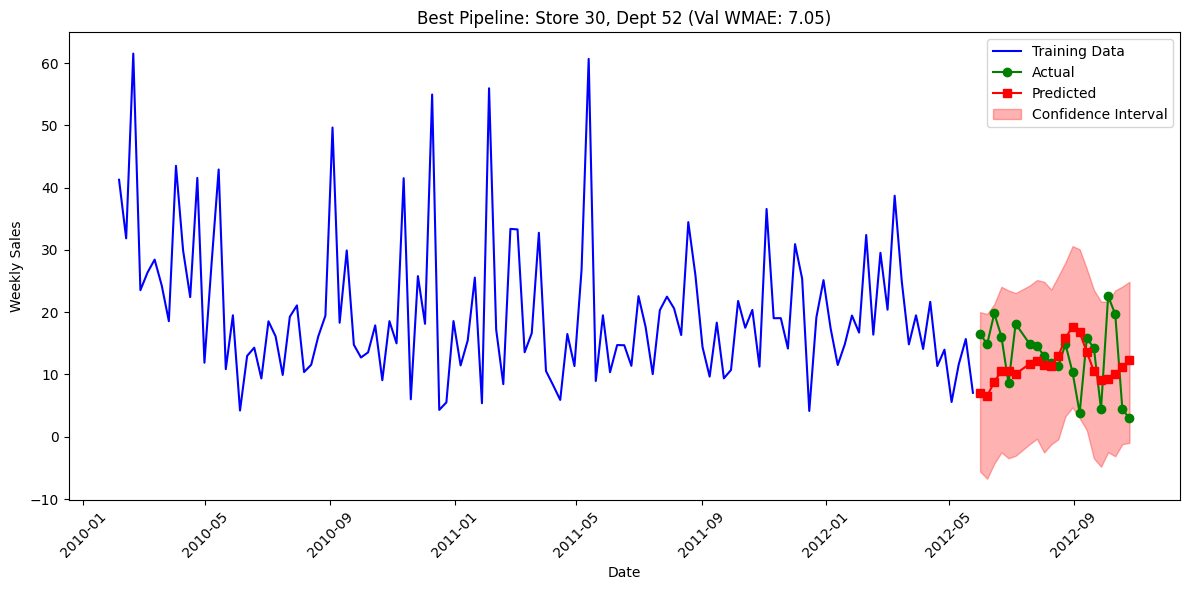


Processed 2923 store-department combinations

Overall Performance Statistics:
Training WMAE - Mean: 1802.9450, Median: 953.8158
Validation WMAE - Mean: 1626.5661, Median: 911.7881
Overfitting Ratio - Mean: 1.2429, Median: 1.0069

Model Generalization Analysis:
Models with potential overfitting (ratio > 2.0): 299 (10.2%)
Well-generalized models (ratio < 1.2): 1861 (63.7%)

Top 10 best performing combinations (by validation WMAE):
      Store  Dept  Train_WMAE  Val_WMAE  Overfitting_Ratio Store_Type  \
2018     30    52      7.6816    7.0453             0.9172          C   
932      14    51      9.2151    7.2150             0.7830          A   
187       3    59    107.8532    7.4584             0.0692          B   
2482     38    52      7.4550    7.8065             1.0472          C   
2739     42    52      9.9876    8.6189             0.8630          C   
2192     33    12      8.2677    8.6767             1.0495          A   
2833     44    52     10.7506    8.9535             0.8

In [43]:
with mlflow.start_run(run_name="prophet_pipeline_with_train_val_comparison"):
    config = ProphetConfig()
    pipeline = create_prophet_pipeline(config)

    prophet_params = config.get_params()
    regressors = config.get_regressors()

    for param_name, param_value in prophet_params.items():
        mlflow.log_param(f"prophet_{param_name}", param_value)

    for regressor_name, regressor_config in regressors.items():
        for config_key, config_value in regressor_config.items():
            mlflow.log_param(f"regressor_{regressor_name}_{config_key}", config_value)

    mlflow.log_param("model_type", "Prophet_Pipeline")
    mlflow.log_param("total_combinations", len(valid_combinations))
    mlflow.log_param("train_end_date", "2012-06-01")
    mlflow.log_param("min_train_size", 60)
    mlflow.log_param("min_val_size", 8)

    batch_size = 50
    results = []
    processed = 0
    total = len(valid_combinations)

    best_val_wmae = float('inf')
    best_pipeline = None
    best_forecast = None
    best_combination = None
    best_train_data = None
    best_val_data = None

    for i in range(0, len(valid_combinations), batch_size):
        batch_combinations = valid_combinations[i:i+batch_size]

        for store, dept in batch_combinations:
            try:
                train_group = train_data[(train_data['Store'] == store) & (train_data['Dept'] == dept)]
                val_group = val_data[(val_data['Store'] == store) & (val_data['Dept'] == dept)]

                if len(train_group) < 30 or len(val_group) < 4:
                    continue

                current_pipeline = create_prophet_pipeline(config)
                current_pipeline.fit(train_group)

                train_predictions = current_pipeline.predict(train_group)
                val_predictions = current_pipeline.predict(val_group)

                train_wmae = WMAE(
                    train_group['Weekly_Sales'].values,
                    train_predictions,
                    train_group['IsHoliday'].values
                )

                val_wmae = WMAE(
                    val_group['Weekly_Sales'].values,
                    val_predictions,
                    val_group['IsHoliday'].values
                )

                overfitting_ratio = val_wmae / train_wmae if train_wmae > 0 else float('inf')

                train_mae = mean_absolute_error(train_group['Weekly_Sales'].values, train_predictions)
                val_mae = mean_absolute_error(val_group['Weekly_Sales'].values, val_predictions)

                if val_wmae < best_val_wmae:
                    best_val_wmae = val_wmae
                    best_pipeline = current_pipeline
                    best_combination = (store, dept)
                    best_train_data = train_group.copy()
                    best_val_data = val_group.copy()

                    preprocessed_val = current_pipeline['preprocessor'].transform(val_group)
                    best_forecast = current_pipeline['prophet'].predict_full(preprocessed_val)

                results.append({
                    'Store': store,
                    'Dept': dept,
                    'Train_WMAE': train_wmae,
                    'Val_WMAE': val_wmae,
                    'Train_MAE': train_mae,
                    'Val_MAE': val_mae,
                    'Overfitting_Ratio': overfitting_ratio,
                    'Train_Size': len(train_group),
                    'Val_Size': len(val_group),
                    'Mean_Sales': train_group['Weekly_Sales'].mean(),
                    'Store_Type': train_group['Type'].iloc[0],
                    'Store_Size': train_group['Size'].iloc[0]
                })

                processed += 1
                if processed % 100 == 0:
                    print(f"Processed {processed}/{total} combinations")
                    current_results = pd.DataFrame(results)
                    mlflow.log_metric("avg_train_wmae_so_far", current_results['Train_WMAE'].mean(), step=processed)
                    mlflow.log_metric("avg_val_wmae_so_far", current_results['Val_WMAE'].mean(), step=processed)
                    mlflow.log_metric("avg_overfitting_ratio_so_far", current_results['Overfitting_Ratio'].mean(), step=processed)
                    mlflow.log_metric("best_val_wmae_so_far", current_results['Val_WMAE'].min(), step=processed)

            except Exception as e:
                print(f"Error processing Store {store}, Dept {dept}: {str(e)}")
                continue

    results_df = pd.DataFrame(results)

    if len(results_df) > 0:
        mlflow.log_metric("final_avg_train_wmae", results_df['Train_WMAE'].mean())
        mlflow.log_metric("final_median_train_wmae", results_df['Train_WMAE'].median())
        mlflow.log_metric("final_best_train_wmae", results_df['Train_WMAE'].min())
        mlflow.log_metric("final_worst_train_wmae", results_df['Train_WMAE'].max())

        mlflow.log_metric("final_avg_val_wmae", results_df['Val_WMAE'].mean())
        mlflow.log_metric("final_median_val_wmae", results_df['Val_WMAE'].median())
        mlflow.log_metric("final_best_val_wmae", results_df['Val_WMAE'].min())
        mlflow.log_metric("final_worst_val_wmae", results_df['Val_WMAE'].max())

        mlflow.log_metric("final_avg_overfitting_ratio", results_df['Overfitting_Ratio'].mean())
        mlflow.log_metric("final_median_overfitting_ratio", results_df['Overfitting_Ratio'].median())

        overfitting_models = len(results_df[results_df['Overfitting_Ratio'] > 2.0])
        well_generalized_models = len(results_df[results_df['Overfitting_Ratio'] < 1.2])

        mlflow.log_metric("overfitting_models_count", overfitting_models)
        mlflow.log_metric("well_generalized_models_count", well_generalized_models)
        mlflow.log_metric("total_successful_models", len(results_df))

        mlflow.log_metric("final_avg_train_mae", results_df['Train_MAE'].mean())
        mlflow.log_metric("final_avg_val_mae", results_df['Val_MAE'].mean())

        store_type_performance = results_df.groupby('Store_Type').agg({
            'Train_WMAE': ['mean', 'median'],
            'Val_WMAE': ['mean', 'median'],
            'Overfitting_Ratio': ['mean', 'median']
        }).round(4)

        for store_type in store_type_performance.index:
            mlflow.log_metric(f"train_wmae_mean_store_type_{store_type}",
                            store_type_performance.loc[store_type, ('Train_WMAE', 'mean')])
            mlflow.log_metric(f"val_wmae_mean_store_type_{store_type}",
                            store_type_performance.loc[store_type, ('Val_WMAE', 'mean')])
            mlflow.log_metric(f"overfitting_ratio_mean_store_type_{store_type}",
                            store_type_performance.loc[store_type, ('Overfitting_Ratio', 'mean')])

        plt.figure(figsize=(16, 12))

        plt.subplot(2, 3, 1)
        plt.scatter(results_df['Train_WMAE'], results_df['Val_WMAE'], alpha=0.6)
        plt.plot([results_df['Train_WMAE'].min(), results_df['Train_WMAE'].max()],
                [results_df['Train_WMAE'].min(), results_df['Train_WMAE'].max()], 'r--', label='Perfect Fit')
        plt.xlabel('Training WMAE')
        plt.ylabel('Validation WMAE')
        plt.title('Training vs Validation WMAE')
        plt.legend()

        plt.subplot(2, 3, 2)
        plt.hist(results_df['Overfitting_Ratio'], bins=30, alpha=0.7)
        plt.axvline(x=1.0, color='g', linestyle='--', label='No Overfitting')
        plt.axvline(x=2.0, color='r', linestyle='--', label='Overfitting Threshold')
        plt.xlabel('Overfitting Ratio (Val/Train)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Overfitting Ratios')
        plt.legend()

        plt.subplot(2, 3, 3)
        store_type_stats = results_df.groupby('Store_Type').agg({
            'Train_WMAE': 'mean',
            'Val_WMAE': 'mean'
        })

        x_pos = np.arange(len(store_type_stats.index))
        width = 0.35

        plt.bar(x_pos - width/2, store_type_stats['Train_WMAE'], width, label='Train WMAE', alpha=0.8)
        plt.bar(x_pos + width/2, store_type_stats['Val_WMAE'], width, label='Val WMAE', alpha=0.8)
        plt.xlabel('Store Type')
        plt.ylabel('Average WMAE')
        plt.title('Performance by Store Type')
        plt.xticks(x_pos, store_type_stats.index)
        plt.legend()

        plt.subplot(2, 3, 4)
        plt.scatter(results_df['Mean_Sales'], results_df['Val_WMAE'], alpha=0.6)
        plt.xlabel('Mean Sales')
        plt.ylabel('Validation WMAE')
        plt.title('Val WMAE vs Mean Sales')

        plt.subplot(2, 3, 5)
        results_df.boxplot(column='Val_WMAE', by='Store_Type', ax=plt.gca())
        plt.title('Val WMAE by Store Type')
        plt.suptitle('')

        plt.subplot(2, 3, 6)
        plt.scatter(results_df['Store_Size'], results_df['Val_WMAE'], alpha=0.6)
        plt.xlabel('Store Size')
        plt.ylabel('Validation WMAE')
        plt.title('Val WMAE vs Store Size')

        plt.tight_layout()
        plt.savefig('prophet_pipeline_analysis_with_training.png', dpi=300, bbox_inches='tight')
        mlflow.log_artifact('prophet_pipeline_analysis_with_training.png')
        plt.show()

        if best_pipeline is not None:
            print(f"\nBest model: Store {best_combination[0]}, Dept {best_combination[1]}")
            print(f"Training WMAE: {results_df.loc[results_df['Val_WMAE'].idxmin(), 'Train_WMAE']:.4f}")
            print(f"Validation WMAE: {best_val_wmae:.4f}")
            print(f"Overfitting Ratio: {results_df.loc[results_df['Val_WMAE'].idxmin(), 'Overfitting_Ratio']:.4f}")

            mlflow.log_param("best_store", best_combination[0])
            mlflow.log_param("best_dept", best_combination[1])
            mlflow.log_metric("best_model_train_wmae", results_df.loc[results_df['Val_WMAE'].idxmin(), 'Train_WMAE'])
            mlflow.log_metric("best_model_val_wmae", best_val_wmae)
            mlflow.log_metric("best_model_overfitting_ratio", results_df.loc[results_df['Val_WMAE'].idxmin(), 'Overfitting_Ratio'])

            joblib.dump(best_pipeline, 'best_prophet_pipeline.pkl')
            mlflow.log_artifact('best_prophet_pipeline.pkl')

            plt.figure(figsize=(12, 6))
            plt.plot(best_train_data['Date'], best_train_data['Weekly_Sales'],
                    label='Training Data', color='blue')
            plt.plot(best_val_data['Date'], best_val_data['Weekly_Sales'],
                    label='Actual', color='green', marker='o')
            plt.plot(best_val_data['Date'], best_forecast['yhat'],
                    label='Predicted', color='red', marker='s')
            plt.fill_between(best_val_data['Date'], best_forecast['yhat_lower'],
                           best_forecast['yhat_upper'],
                           alpha=0.3, color='red', label='Confidence Interval')
            plt.title(f'Best Pipeline: Store {best_combination[0]}, Dept {best_combination[1]} (Val WMAE: {best_val_wmae:.2f})')
            plt.xlabel('Date')
            plt.ylabel('Weekly Sales')
            plt.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig('best_pipeline_forecast.png', dpi=300, bbox_inches='tight')
            mlflow.log_artifact('best_pipeline_forecast.png')
            plt.show()

        print(f"\nProcessed {len(results_df)} store-department combinations")
        print(f"\nOverall Performance Statistics:")
        print(f"Training WMAE - Mean: {results_df['Train_WMAE'].mean():.4f}, Median: {results_df['Train_WMAE'].median():.4f}")
        print(f"Validation WMAE - Mean: {results_df['Val_WMAE'].mean():.4f}, Median: {results_df['Val_WMAE'].median():.4f}")
        print(f"Overfitting Ratio - Mean: {results_df['Overfitting_Ratio'].mean():.4f}, Median: {results_df['Overfitting_Ratio'].median():.4f}")

        print(f"\nModel Generalization Analysis:")
        print(f"Models with potential overfitting (ratio > 2.0): {overfitting_models} ({overfitting_models/len(results_df)*100:.1f}%)")
        print(f"Well-generalized models (ratio < 1.2): {well_generalized_models} ({well_generalized_models/len(results_df)*100:.1f}%)")

        print(f"\nTop 10 best performing combinations (by validation WMAE):")
        best_models = results_df.nsmallest(10, 'Val_WMAE')[['Store', 'Dept', 'Train_WMAE', 'Val_WMAE', 'Overfitting_Ratio', 'Store_Type', 'Mean_Sales']]
        print(best_models.round(4))

        print(f"\nPerformance by Store Type:")
        print(store_type_performance)